In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from project_utils import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

%matplotlib inline

Global parameters to be tweaked are in the next cell. These are necessary both for training and test.

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

Read in the car and non-car training images and plot an example image from each. Following that is a HOG visualization for the two example images.

(-0.5, 63.5, 63.5, -0.5)

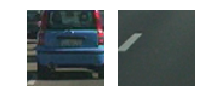

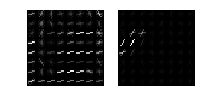

In [3]:
# Read in cars and notcars
images = glob.glob('./vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)
images = glob.glob('./non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)
    
fig, axs = plt.subplots(1, 2, figsize=(3,6))
fig.subplots_adjust(wspace=.2)
axs = axs.ravel()
axs[0].imshow(mpimg.imread(cars[10]))
axs[0].axis('off')
axs[1].imshow(mpimg.imread(notcars[10]))
axs[1].axis('off')

img_Ych_car = convert_color(mpimg.imread(cars[10]))[:,:,0]
features, hog_image_car = get_hog_features(img_Ych_car,orient, pix_per_cell, cell_per_block,vis=True)
img_Ych_notcar = convert_color(mpimg.imread(notcars[10]))[:,:,0]
features, hog_image_notcar = get_hog_features(img_Ych_notcar,orient, pix_per_cell, cell_per_block,vis=True)

fig, axs = plt.subplots(1, 2, figsize=(3,6))
fig.subplots_adjust(wspace=.2)
axs = axs.ravel()
axs[0].imshow(hog_image_car, cmap='gray')
axs[0].axis('off')
axs[1].imshow(hog_image_notcar, cmap = 'gray')
axs[1].axis('off')


Extract features

In [4]:
t1 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract features...')

72.02 Seconds to extract features...


Scale the data and train the classifier

In [5]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler=StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Check the training time for the SVC
t3=time.time()
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
t4 = time.time()
print(round(t4-t3, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5508
28.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9848


Hog subsampling function as well as a sliding window for vehicle detection

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, step = 2, showAll = False):
 
    # Following globals are available
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255 # Has been scaled prior to function call
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) +1 #- cell_per_block 
    nyblocks = (ch1.shape[0] // pix_per_cell) +1 #- cell_per_block 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = []
            if hog_feat == True:
                if hog_channel == 0:
                    hog_features = hog_feat1 #
                elif hog_channel == 1:
                    hog_features = hog_feat2
                elif hog_channel == 2:
                    hog_features = hog_feat3
                elif hog_channel == 'ALL':
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = []
            hist_features = []
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or showAll:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                left_top = (xbox_left+xstart, ytop_draw+ystart)
                right_bottom = (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)
                bbox_list.append((left_top, right_bottom))
                    
    return bbox_list


Visualization of the sliding windows

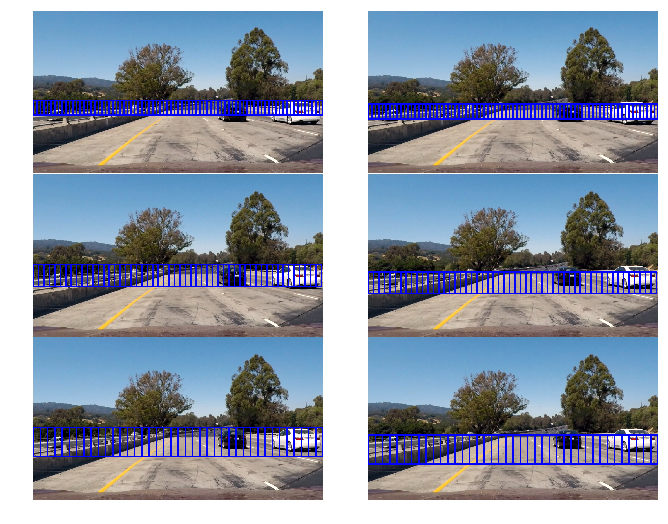

In [7]:
draw_image = mpimg.imread('./test_images/test1.jpg')
combos = [(400,464,1.0),(416,480,1.0),(400,496,1.5),(432,528,1.5),(400,528,2.0),(432,560,2.0)]
bbox_list = []
fig, axs = plt.subplots(3, 2, figsize=(12,9))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()
for ii, combo in enumerate(combos):
    bblist = find_cars(draw_image,combo[0],combo[1],0,1280,combo[2],2,True)
    draw_image1 = draw_boxes(draw_image,bblist)   
    axs[ii].imshow(draw_image1)
    axs[ii].axis('off')

A function that processes a single image and 
* does a sliding window search on various image sections with different scales
* maintains a heatmap that adds contributions from all the detected bounding boxes
* maintains an accumulated heatmap with a configurable integration length (15 frames of the video)
* thresholds the heatmap to remove false detections

In [8]:
integration_length = 15
heat_history = [np.zeros((720,1280)).astype(np.float) for ii in range(integration_length)]
ind = 0
def process_image(image,showheat=False):
    global ind, integration_length, heat_history
    draw_image = np.copy(image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    bbox_list = []
    combos = [(400,464,1.0),(416,480,1.0),(400,496,1.5),(432,528,1.5),(400,528,2.0),(432,560,2.0)]
    for combo in combos:
        bblist = find_cars(image,combo[0],combo[1],0,1280,combo[2])
        bbox_list = bbox_list + bblist
    #print(bbox_list)
    current_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    current_heat = add_heat(current_heat,bbox_list)
    heat_history[ind % integration_length] = np.copy(current_heat)
    heat = np.copy(heat_history[0])
    for ii in range(1,integration_length):
        heat += heat_history[ii]        

    heat = apply_threshold(heat,integration_length//2 + 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_image1 = draw_boxes(draw_image,bbox_list)
    draw_image,dummy = draw_labeled_bboxes(draw_image, labels)
    #cv2.imshow('image',draw_image)
    #cv2.waitKey(2)
    if showheat:
        plt.imshow(heatmap,cmap = 'hot')
    ind += 1
    return draw_image

First run the function on the set of test images. 
* In this case, do not integrate over successive images

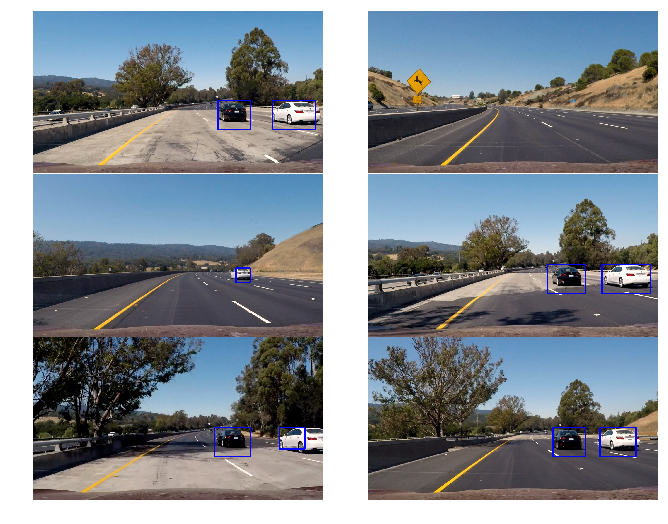

In [9]:
imagefiles = ['./test_images/test1.jpg',
          './test_images/test2.jpg',
          './test_images/test3.jpg',
          './test_images/test4.jpg',
          './test_images/test5.jpg',
          './test_images/test6.jpg']
# Do not integrate over successive images
integration_length = 1
# Initialize globals
heat_history = [np.zeros((720,1280)).astype(np.float) for ii in range(integration_length)]
ind = 0

fig, axs = plt.subplots(3, 2, figsize=(12,9))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()
for ii, imagefile in enumerate(imagefiles):
    axs[ii].imshow(process_image(mpimg.imread(imagefile)))
    axs[ii].axis('off')

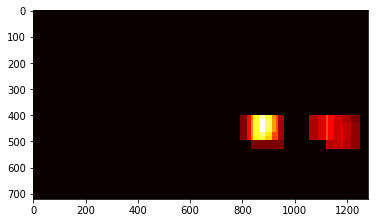

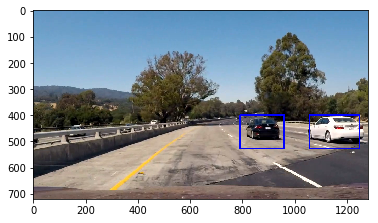

In [10]:
clip = VideoFileClip('./test_video.mp4')
ind = 0
integration_length = 15
heat_history = [np.zeros((720,1280)).astype(np.float) for ii in range(integration_length)]
for image in clip.iter_frames():
    boxed_image = process_image(image,True)
plt.figure()
plt.imshow(boxed_image)

Apply the pipeline to the video.
* In this case, use an integration length of 15 frames

In [22]:
# Integrate over 15 frames
integration_length = 15
# Initialize globals
heat_history = [np.zeros((720,1280)).astype(np.float) for ii in range(integration_length)]
ind = 0

clip = VideoFileClip('./project_video.mp4')

outfile  = 'project_video_out.mp4'
outclip = clip.fl_image(process_image)
%time outclip.write_videofile(outfile, audio=False)
del clip.reader
del clip

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [09:43<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 19min 34s, sys: 2.67 s, total: 19min 37s
Wall time: 9min 44s


In [23]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))

# Junk stuff here, don't run this cell
    bbox_list = find_cars(image, 400, 650, 950, 1280, 2.0)
    bbox_list += find_cars(image, 400, 500, 950, 1280, 1.5)
    bbox_list += find_cars(image, 400, 650, 0, 330, 2.0)
    bbox_list += find_cars(image, 400, 500, 0, 330, 1.5)
    bbox_list += find_cars(image, 400, 460, 330, 950, 0.75,3)
    bbox_list = []
    for scale in [1,1.5,2]:
        bblist = find_cars(image, 400, 656,0,1280,scale)
        bbox_list = bbox_list + bblist
    for oldbb in thresh_bblist:
        eleft, eright = expand_bbox(oldbb,1.25)
        eleft = np.maximum(eleft,[0,0]).astype(int)
        eright = np.minimum(eright,[1280,720]).astype(int)
        bbox_list += find_cars(image,eleft[1],eright[1],eleft[0],eright[0],1.25,2)
        bbox_list += find_cars(image,eleft[1],eright[1],eleft[0],eright[0],0.75,2)
    #print(thresh_bblist)
    if ind%plot_frequency == 0:
        plt.figure()
        plt.imshow(draw_image)
 
